In [36]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, Conv2D, GlobalMaxPooling2D,GlobalMaxPooling1D, MaxPool1D, MaxPool2D
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [25]:
multiclass_train = pd.read_csv("multiclass_train.csv")
multiclass_test = pd.read_csv("multiclass_test.csv")

In [26]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass_train[" Label"] = le.fit_transform(multiclass_train[" Label"].values)

multiclass_test[" Label"] = le.transform(multiclass_test[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass_train[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [27]:
y_train = multiclass_train[" Label"].copy()
X_train = multiclass_train.drop([" Label"], axis=1)

y_test = multiclass_test[" Label"].copy()
X_test = multiclass_test.drop([" Label"], axis=1)

In [28]:
scal = StandardScaler()
scal = scal.fit(X_train)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, stratify=y_train, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [29]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), n_feat, 1))
X_vl = np.reshape(X_val, (len(X_val), n_feat, 1))
X_tst = np.reshape(X_test, (len(X_test), n_feat, 1))

In [30]:
print(X_tr.shape)
print(y_train.shape)

(139993, 80, 1)
(139993,)


In [66]:
model = keras.Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=X_tr.shape[1:3]))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 256, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 512, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))

opt = keras.optimizers.Adadelta(learning_rate=0.1)
#opt = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay = 5e-3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_51 (Conv1D)          (None, 78, 64)            256       
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 39, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_52 (Conv1D)          (None, 37, 128)           24704     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 18, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 16, 256)           98560     
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 8, 256)         

In [67]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=128, epochs=100, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/100
1094/1094 [==============================] - 9s 8ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.5350 - val_loss: 0.8796 - val_sparse_categorical_accuracy: 0.6072 - lr: 0.1000
Epoch 2/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.8359 - sparse_categorical_accuracy: 0.6078 - val_loss: 0.8211 - val_sparse_categorical_accuracy: 0.6094 - lr: 0.1000
Epoch 3/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.7929 - sparse_categorical_accuracy: 0.6145 - val_loss: 0.7828 - val_sparse_categorical_accuracy: 0.6030 - lr: 0.1000
Epoch 4/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.7647 - sparse_categorical_accuracy: 0.6198 - val_loss: 0.7580 - val_sparse_categorical_accuracy: 0.6022 - lr: 0.1000
Epoch 5/100
1094/1094 [==============================] - 8s 8ms/step - loss: 0.7479 - sparse_categorical_accuracy: 0.6233 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.6166 - lr: 0.1000
Epoch 6/100
1094/109

In [68]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "CNN_multi_final.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


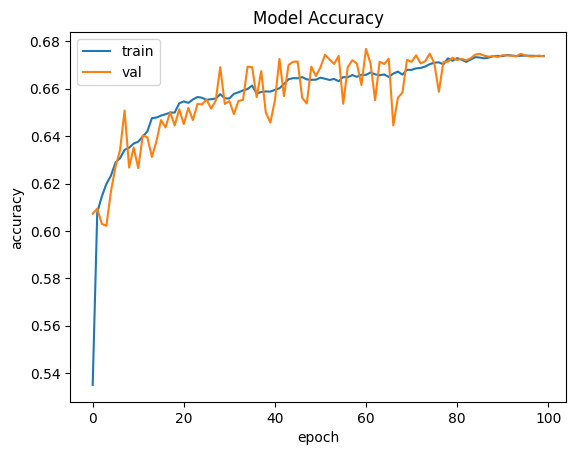

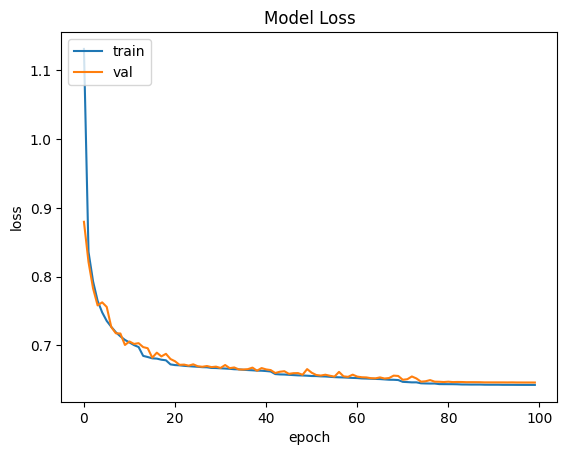

In [69]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
#Test predictions
#model.load_weights(checkpoint_filepath)
prediction = model.predict(X_tst)

1250/1250 [==============================] - 2s 2ms/step


In [74]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

5     5508
10    4859
6     4247
11    4241
1     4149
2     3583
9     3304
3     3228
7     2146
8     1957
0     1501
4     1276
dtype: int64

In [75]:
print(classification_report(y_test.to_numpy(), pred, digits=6,target_names=multiclass_labels))

              precision    recall  f1-score   support

         DNS   0.622918  0.280528  0.386843      3333
        LDAP   0.528561  0.657966  0.586207      3333
       MSSQL   0.863243  0.927993  0.894448      3333
         NTP   0.989467  0.958008  0.973484      3334
     NetBIOS   0.551724  0.211221  0.305489      3333
     Portmap   0.507081  0.837984  0.631829      3333
        SNMP   0.657641  0.837732  0.736842      3334
        SSDP   0.466449  0.300240  0.365328      3334
         Syn   0.960143  0.563756  0.710397      3333
        TFTP   0.989709  0.981098  0.985385      3333
         UDP   0.471496  0.687369  0.559326      3333
     UDP-lag   0.649611  0.826583  0.727489      3333

    accuracy                       0.672542     39999
   macro avg   0.688170  0.672540  0.655256     39999
weighted avg   0.688172  0.672542  0.655258     39999



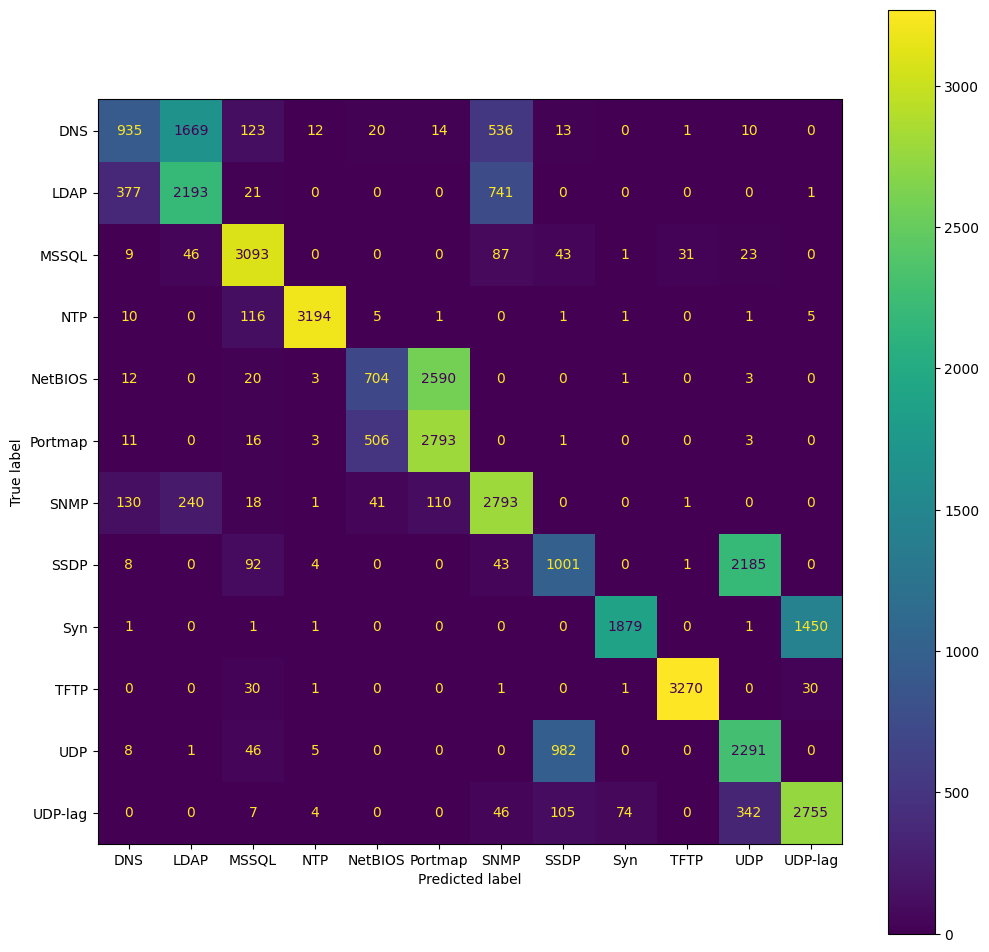

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_multi_cnn.png")